# Goal of the notebook

So far we have claimed that additional features will be helpful in terms of our analysis. Now it is time to test this hypothesis, as well as to try advanced ML models. As a result, we will figure out which features do indeed determine options prices, and whether we can beat benchmark (Black-Scholes model) or not.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# 1167991
dataset_full = pd.read_csv('6_More_features_06_05.csv')
dataset_full

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (3,4,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Contract Name,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Company,...,l1_Stock_volume,l2_Stock_volume,l3_Stock_volume,l4_Stock_volume,l5_Stock_volume,l6_Stock_volume,l7_Stock_volume,l8_Stock_volume,l9_Stock_volume,l10_Stock_volume
0,AAPL240301C00095000,95.0,93.48,87.2,87.95,0.0,-,-,1.0,AAPL,...,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0
1,AAPL240301C00095000,95.0,93.48,87.2,87.95,0.0,-,-,1.0,AAPL,...,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0
2,AAPL240301C00095000,95.0,93.48,85.8,86.2,0.0,-,-,1.0,AAPL,...,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0
3,AAPL240301C00095000,95.0,93.48,86.4,86.7,0.0,-,-,1.0,AAPL,...,53665600.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0
4,AAPL240301C00095000,95.0,93.48,88.75,89.1,0.0,-,-,1.0,AAPL,...,41529700.0,53665600.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167986,INTC240503C00060000,60.0,0.02,0.0,0.25,0.0,-,111,158,INTC,...,57307200.0,83718000.0,32748400.0,31712600.0,54204200.0,54204200.0,51017800.0,39109700.0,54204200.0,54204200.0
1167987,INTC240503C00060000,60.0,0.02,0.0,0.05,0.0,-,111,158,INTC,...,56967800.0,57307200.0,83718000.0,32748400.0,31712600.0,54204200.0,54204200.0,51017800.0,39109700.0,54204200.0
1167988,INTC240503C00060000,60.0,0.02,0.0,0.04,0.0,-,10,158,INTC,...,78783000.0,56967800.0,57307200.0,83718000.0,32748400.0,31712600.0,54204200.0,54204200.0,51017800.0,39109700.0
1167989,INTC240503C00060000,60.0,0.02,0.0,0.05,0.0,-,10,168,INTC,...,51108400.0,78783000.0,56967800.0,57307200.0,83718000.0,32748400.0,31712600.0,54204200.0,54204200.0,51017800.0


In [3]:
dataset_full['Volume'] = dataset_full['Volume'].str.replace('-', '0') # make it the proper type
dataset_full = dataset_full.drop(['Open Interest'], axis=1) # more than half nans
dataset_full['Volume'] = dataset_full['Volume'].astype('float')

In [4]:
# drop either useless features or data leakages
data = dataset_full.copy()
data = data.drop(['Contract Name', '% Change', 'Date_expiration',
                 'Bid', 'Ask'], axis=1)

data = data.set_index('Date_get_data')

In [5]:
data.dtypes

Strike                     float64
Last Price                 float64
Change                     float64
Volume                     float64
Company                     object
Time_to_maturity           float64
r                          float64
Stock_price                float64
Stock_volume               float64
Black_Scholes                int64
Option_price_volatility    float64
Capitalization             float64
Age                          int64
Weight                     float64
l1_Last Price              float64
l2_Last Price              float64
l3_Last Price              float64
l4_Last Price              float64
l5_Last Price              float64
l6_Last Price              float64
l7_Last Price              float64
l8_Last Price              float64
l9_Last Price              float64
l10_Last Price             float64
l1_Stock_price             float64
l2_Stock_price             float64
l3_Stock_price             float64
l4_Stock_price             float64
l5_Stock_price      

# Check which features are important (excluding dummies)

In [6]:
X1 = data.drop(['Last Price', 'Company'], axis=1)
y1 = data[['Last Price']]

In [7]:
X1.head()

,Strike,Change,Volume,Time_to_maturity,r,Stock_price,Stock_volume,Black_Scholes,Option_price_volatility,Capitalization,...,l1_Stock_volume,l2_Stock_volume,l3_Stock_volume,l4_Stock_volume,l5_Stock_volume,l6_Stock_volume,l7_Stock_volume,l8_Stock_volume,l9_Stock_volume,l10_Stock_volume
Date_get_data,,,,,,,,,,,,,,,,,,,,,
2024-02-16,95.0,0.0,0.0,0.038356,0.04,182.309998,49701400.0,96,3.64518,2831.0,...,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0
2024-02-19,95.0,0.0,0.0,0.030137,0.04,182.309998,49701400.0,93,3.64518,2831.0,...,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0
2024-02-20,95.0,0.0,0.0,0.027397,0.04,181.559998,53665600.0,92,3.64518,2831.0,...,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0
2024-02-21,95.0,0.0,0.0,0.024658,0.04,182.320007,41529700.0,92,3.64518,2831.0,...,53665600.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0
2024-02-22,95.0,0.0,0.0,0.021918,0.04,184.369995,52292200.0,93,3.64518,2831.0,...,41529700.0,53665600.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0


**Short feature description (except for obvious ones)**:

+ Black_Scholes - we will use outputs from the Black-Scholes model as additional features (because why not?)


+ li_Last Price - i-th lag of the price of the contract


+ li_Stock_price - i-th lag of the price of the underlying asset


+ li_Stock_volume - i-th lag of the traded volume of the underlying asset

In [8]:
import statsmodels.api as sm
X_constant = sm.add_constant(X1)
lin_reg = sm.OLS(y1, X_constant).fit()
lin_reg.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Last Price   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 9.952e+06
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        13:42:03   Log-Likelihood:            -4.1009e+06
No. Observations:             1167991   AIC:                         8.202e+06
Df Residuals:                 1167949   BIC:                         8.202e+06
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Strike                      0.0001   2.98e-05      4.055      0.000    6.25e-05       0.000
Change                      0.7651      0.001    837.951      0.000       0.763       0.767
Volume                  -1.762e-05   3.77e-06     -4.677      0.000    -2.5e-05   -1.02e-05
Time_to_maturity           -0.0215      0.012     -1.823      0.068      -0.045       0.002
r                           5.4901      0.615      8.933      0.000       4.285       6.695
Stock_price                 0.2181      0.001    423.969      0.000       0.217       0.219
Stock_volume             2.136e-08   7.38e-10     28.958      0.000    1.99e-08    2.28e-08
Black_Scholes            -1.64e-05   4.88e-05     -0.336      0.737      -0.000    7.92e-05
Option_price_volatility    -0.0095      0.001    -17.239      0.000      -0.011      -0.008
Capitalization          -6.948e-05      4e-05     -1.736      0.082      -0.000    8.94e-06
Age                        -0.0007      0.000     -3.222      0.001      -0.001      -0.000
Weight                      0.0214      0.018      1.163      0.245      -0.015       0.058
l1_Last Price               0.9406      0.001   1277.905      0.000       0.939       0.942
l2_Last Price               0.0198      0.001     19.646      0.000       0.018       0.022
l3_Last Price               0.0073      0.001      7.154      0.000       0.005       0.009
l4_Last Price               0.0286      0.001     27.803      0.000       0.027       0.031
l5_Last Price              -0.0234      0.001    -22.526      0.000      -0.025      -0.021
l6_Last Price               0.0090      0.001      8.602      0.000       0.007       0.011
l7_Last Price               0.0028      0.001      2.598      0.009       0.001       0.005
l8_Last Price               0.0113      0.001     10.517      0.000       0.009       0.013
l9_Last Price              -0.0025      0.001     -2.309      0.021      -0.005      -0.000
l10_Last Price              0.0052      0.001      6.570      0.000       0.004       0.007
l1_Stock_price             -0.1657      0.001   -225.734      0.000      -0.167      -0.164
l2_Stock_price             -0.0010      0.001     -1.308      0.191      -0.003       0.001
l3_Stock_price             -0.0328      0.001    -42.130      0.000      -0.034      -0.031
l4_Stock_price              0.0423      0.001     53.040      0.000       0.041       0.044
l5_Stock_price             -0.0594      0.001    -72.704      0.000      -0.061      -0.058
l6_Stock_price              0.0246      0.001     30.055      0.000       0.023       0.026
l7_Stock_price             -0.0256      0.001    -31.251      0.000      -0.027      -0.024
l8_Stock_price              0.0103      0.001     12.601      0.000       0.009       0.012
l9_Stock_price              0.0275      0.001  

# Apply Linear Regression on all features (including dummy features)

In [9]:
data = pd.get_dummies(data, drop_first=True)

In [10]:
X = data.drop('Last Price', axis=1)
y = data[['Last Price']]

In [11]:
pd.set_option('display.max_columns', None)

In [12]:
X.head()

,Strike,Change,Volume,Time_to_maturity,r,Stock_price,Stock_volume,Black_Scholes,Option_price_volatility,Capitalization,Age,Weight,l1_Last Price,l2_Last Price,l3_Last Price,l4_Last Price,l5_Last Price,l6_Last Price,l7_Last Price,l8_Last Price,l9_Last Price,l10_Last Price,l1_Stock_price,l2_Stock_price,l3_Stock_price,l4_Stock_price,l5_Stock_price,l6_Stock_price,l7_Stock_price,l8_Stock_price,l9_Stock_price,l10_Stock_price,l1_Stock_volume,l2_Stock_volume,l3_Stock_volume,l4_Stock_volume,l5_Stock_volume,l6_Stock_volume,l7_Stock_volume,l8_Stock_volume,l9_Stock_volume,l10_Stock_volume,Company_ACN,Company_AMZN,Company_AVGO,Company_BAC,Company_CSCO,Company_DG,Company_DIS,Company_GOOGL,Company_INTC,Company_JNJ,Company_JPM,Company_KO,Company_LLY,Company_LMT,Company_MA,Company_MCD,Company_META,Company_MRK,Company_MSFT,Company_NFLX,Company_NVDA,Company_ORCL,Company_PEP,Company_PFE,Company_PG,Company_PYPL,Company_QCOM,Company_SPY,Company_TSLA,Company_TSN,Company_UNH,Company_V,Company_VZ,Company_WMT
Date_get_data,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-02-16,95.0,0.0,0.0,0.038356,0.04,182.309998,49701400.0,96,3.64518,2831.0,48,5.91,89.37,89.37,89.37,89.37,89.37,89.37,89.37,89.37,89.37,89.37,182.309998,182.309998,182.309998,182.309998,182.309998,182.309998,182.309998,182.309998,182.309998,182.309998,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2024-02-19,95.0,0.0,0.0,0.030137,0.04,182.309998,49701400.0,93,3.64518,2831.0,48,5.91,93.48,89.37,89.37,89.37,89.37,89.37,89.37,89.37,89.37,89.37,182.309998,182.309998,182.309998,182.309998,182.309998,182.309998,182.309998,182.309998,182.309998,182.309998,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2024-02-20,95.0,0.0,0.0,0.027397,0.04,181.559998,53665600.0,92,3.64518,2831.0,48,5.91,93.48,93.48,89.37,89.37,89.37,89.37,89.37,89.37,89.37,89.37,182.309998,182.309998,182.309998,182.309998,182.309998,182.309998,182.309998,182.309998,182.309998,182.309998,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2024-02-21,95.0,0.0,0.0,0.024658,0.04,182.320007,41529700.0,92,3.64518,2831.0,48,5.91,93.48,93.48,93.48,89.37,89.37,89.37,89.37,89.37,89.37,89.37,181.559998,182.309998,182.309998,182.309998,182.309998,182.309998,182.309998,182.309998,182.309998,182.309998,53665600.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2024-02-22,95.0,0.0,0.0,0.021918,0.04,184.369995,52292200.0,93,3.64518,2831.0,48,5.91,93.48,93.48,93.48,93.48,89.37,89.37,89.37,89.37,89.37,89.37,182.320007,181.559998,182.309998,182.309998,182.309998,182.309998,182.309998,182.309998,182.309998,182.309998,41529700.0,53665600.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,49701400.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)
y_pred_1 = model.predict(X)

In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [15]:
MSE_linreg_unresticted = mean_squared_error(y, y_pred_1)
MAE_linreg_unresticted = mean_absolute_error(y, y_pred_1)
MAPE_linreg_unresticted = mean_absolute_percentage_error(y, y_pred_1)

In [16]:
MSE_linreg_unresticted, MAE_linreg_unresticted, MAPE_linreg_unresticted

(65.47705796161793, 2.3328187803075036, 2.944039729327143)

# See where the biggest mistakes are

In [17]:
# create an array with mistakes (APE - absolute percentage error between the true target and the prediction)
y_1 = np.array(y)
y_pred_1 = np.array(y_pred_1)
mistakes = pd.DataFrame(y_1)
mistakes.columns = ['y_true']
mistakes['y_pred'] = y_pred_1
mistakes['APE'] = np.abs(mistakes['y_true'] - mistakes['y_pred']) / mistakes['y_true']
mistakes.sample(frac=0.00001)

,y_true,y_pred,APE
148495,15.15,13.524996,0.107261
210073,46.04,46.195937,0.003387
796504,475.80,448.148504,0.058116
116660,68.23,68.237660,0.000112
131634,0.79,0.374138,0.526407
153626,31.83,31.244589,0.018392
986763,0.05,1.587843,30.756851
183750,146.94,147.000814,0.000414
296155,48.30,48.031650,0.005556
836401,264.14,261.151629,0.011314


In [18]:
mistakes['APE'].describe()

count    1.167991e+06
mean     2.944040e+00
std      2.151057e+01
min      8.204921e-09
25%      8.045282e-03
50%      2.873293e-02
75%      1.807521e-01
max      2.352930e+03
Name: APE, dtype: float64

In [19]:
# median is very less than the mean!
2.873293e-02, 2.944040e+00

(0.02873293, 2.94404)

In [20]:
# so we see that indeed the biggest mistakes are made for the cheap options
mistakes.sort_values(by='APE', ascending=False).head(20)

,y_true,y_pred,APE
794847,0.01,23.539304,2352.930385
794869,0.01,23.538221,2352.822077
1041287,0.01,22.177623,2216.762322
1044052,0.04,78.158936,1952.973396
600038,0.01,16.018261,1600.826088
1041321,0.05,77.951589,1558.031780
843026,0.01,11.632533,1162.253309
602045,0.01,10.936373,1092.637281
602173,0.01,10.921919,1091.191865
602109,0.01,10.920671,1091.067127


# Hypothesis: get rid of very cheap options and see the results

We will not do it the smart way. We will just cut the cheapest options until the total length of the dataset is approximately 1 000 000. Note that we might slightly violate the time series structure. However, out goal is to test a hypothesis, rather than to create a perfect model

In [21]:
data.shape

(1167991, 77)

In [22]:
data_sorted = data.sort_values(by='Last Price', ascending=False)
data_sorted.tail()

,Strike,Last Price,Change,Volume,Time_to_maturity,r,Stock_price,Stock_volume,Black_Scholes,Option_price_volatility,Capitalization,Age,Weight,l1_Last Price,l2_Last Price,l3_Last Price,l4_Last Price,l5_Last Price,l6_Last Price,l7_Last Price,l8_Last Price,l9_Last Price,l10_Last Price,l1_Stock_price,l2_Stock_price,l3_Stock_price,l4_Stock_price,l5_Stock_price,l6_Stock_price,l7_Stock_price,l8_Stock_price,l9_Stock_price,l10_Stock_price,l1_Stock_volume,l2_Stock_volume,l3_Stock_volume,l4_Stock_volume,l5_Stock_volume,l6_Stock_volume,l7_Stock_volume,l8_Stock_volume,l9_Stock_volume,l10_Stock_volume,Company_ACN,Company_AMZN,Company_AVGO,Company_BAC,Company_CSCO,Company_DG,Company_DIS,Company_GOOGL,Company_INTC,Company_JNJ,Company_JPM,Company_KO,Company_LLY,Company_LMT,Company_MA,Company_MCD,Company_META,Company_MRK,Company_MSFT,Company_NFLX,Company_NVDA,Company_ORCL,Company_PEP,Company_PFE,Company_PG,Company_PYPL,Company_QCOM,Company_SPY,Company_TSLA,Company_TSN,Company_UNH,Company_V,Company_VZ,Company_WMT
Date_get_data,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-20,200.0,0.01,0.0,1.0,0.005479,0.04,148.740005,21311500.0,0,0.005099,2076.0,26,2.31,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,147.029999,147.679993,141.179993,139.789993,138.500000,137.669998,135.410004,134.380005,131.399994,132.669998,24070400.0,69273700.0,49460600.0,23347200.0,27563400.0,32437800.0,39343100.0,37738200.0,35318600.0,40194800.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2024-03-19,200.0,0.01,0.0,1.0,0.008219,0.04,147.029999,24070400.0,0,0.005099,2076.0,26,2.31,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,147.679993,141.179993,139.789993,138.500000,137.669998,135.410004,134.380005,131.399994,132.669998,133.350006,69273700.0,49460600.0,23347200.0,27563400.0,32437800.0,39343100.0,37738200.0,35318600.0,40194800.0,55999400.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2024-03-18,200.0,0.01,0.0,1.0,0.010959,0.04,147.679993,69273700.0,0,0.005099,2076.0,26,2.31,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,141.179993,139.789993,138.500000,137.669998,135.410004,134.380005,131.399994,132.669998,133.350006,137.139999,49460600.0,23347200.0,27563400.0,32437800.0,39343100.0,37738200.0,35318600.0,40194800.0,55999400.0,31119500.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2024-03-15,200.0,0.01,0.0,1.0,0.019178,0.04,141.179993,49460600.0,0,0.005099,2076.0,26,2.31,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.02,139.789993,138.500000,137.669998,135.410004,134.380005,131.399994,132.669998,133.350006,137.139999,137.139999,23347200.0,27563400.0,32437800.0,39343100.0,37738200.0,35318600.0,40194800.0,55999400.0,31119500.0,31119500.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2024-03-02,250.0,0.01,0.0,1.0,0.016438,0.04,178.220001,31956200.0,0,0.000000,1937.0,29,3.97,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,178.220001,176.759995,173.160004,173.539993,174.729996,174.580002,168.589996,167.080002,169.509995,169.509995,31956200.0,53805400.0,28180500.0,31141700.0,44368600.0,55392400.0,44575600.0,41980300.0,48074600.0,48074600.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
data_sorted = data_sorted.iloc[:1000000]
data_sorted.tail()

,Strike,Last Price,Change,Volume,Time_to_maturity,r,Stock_price,Stock_volume,Black_Scholes,Option_price_volatility,Capitalization,Age,Weight,l1_Last Price,l2_Last Price,l3_Last Price,l4_Last Price,l5_Last Price,l6_Last Price,l7_Last Price,l8_Last Price,l9_Last Price,l10_Last Price,l1_Stock_price,l2_Stock_price,l3_Stock_price,l4_Stock_price,l5_Stock_price,l6_Stock_price,l7_Stock_price,l8_Stock_price,l9_Stock_price,l10_Stock_price,l1_Stock_volume,l2_Stock_volume,l3_Stock_volume,l4_Stock_volume,l5_Stock_volume,l6_Stock_volume,l7_Stock_volume,l8_Stock_volume,l9_Stock_volume,l10_Stock_volume,Company_ACN,Company_AMZN,Company_AVGO,Company_BAC,Company_CSCO,Company_DG,Company_DIS,Company_GOOGL,Company_INTC,Company_JNJ,Company_JPM,Company_KO,Company_LLY,Company_LMT,Company_MA,Company_MCD,Company_META,Company_MRK,Company_MSFT,Company_NFLX,Company_NVDA,Company_ORCL,Company_PEP,Company_PFE,Company_PG,Company_PYPL,Company_QCOM,Company_SPY,Company_TSLA,Company_TSN,Company_UNH,Company_V,Company_VZ,Company_WMT
Date_get_data,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-04-04,800.0,0.78,0.30,91.0,0.213699,0.04,510.920013,26476300.0,0,0.245586,1146.00,20,2.29,0.48,0.48,0.48,0.48,0.49,0.610,0.830,0.850,0.910,0.920,506.739990,497.369995,491.350006,485.579987,485.579987,493.859985,495.890015,503.019989,509.579987,507.760010,12099200.0,11081000.0,9247000.0,15212800.0,15212800.0,9989700.0,11205400.0,8380600.0,8117000.0,9712500.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2024-03-28,260.0,0.78,-0.09,485.0,0.136986,0.04,175.789993,77654800.0,12,1.312498,577.85,21,1.17,0.90,0.91,0.58,0.63,0.65,0.680,0.660,0.800,0.560,0.810,179.830002,177.669998,172.630005,170.830002,172.820007,175.660004,171.320007,173.800003,163.570007,169.479996,81804000.0,113186200.0,74228600.0,75454700.0,73178000.0,83846700.0,77271400.0,108214400.0,96971900.0,106524500.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2024-03-22,380.0,0.78,0.00,3.0,0.498630,0.04,170.830002,75454700.0,0,0.497753,577.85,21,1.17,0.78,0.78,0.82,0.71,0.71,0.820,0.950,1.180,1.010,1.000,172.820007,175.660004,171.320007,173.800003,163.570007,169.479996,177.539993,177.770004,175.339996,178.649994,73178000.0,83846700.0,77271400.0,108214400.0,96971900.0,106524500.0,87391700.0,85391500.0,85315300.0,102129000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2024-03-12,526.0,0.78,0.25,411.0,0.027397,0.04,516.780029,73114400.0,9,0.375790,318.27,48,0.60,0.55,0.69,1.37,0.59,0.99,0.455,0.455,0.455,0.455,0.455,511.279999,511.720001,514.809998,509.750000,512.299988,514.880005,514.880005,514.880005,514.880005,514.880005,62557200.0,86425500.0,58652100.0,68382400.0,49799300.0,68988500.0,68988500.0,68988500.0,68988500.0,68988500.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2024-03-06,37.0,0.78,0.03,652.0,0.120548,0.04,35.419998,49149700.0,1,0.352809,291.30,26,0.60,0.80,0.57,0.42,0.42,0.42,0.350,0.330,0.250,0.310,0.280,35.389999,35.150002,34.349998,34.349998,34.520000,34.310001,34.279999,33.610001,33.919998,33.610001,47591600.0,49136400.0,38424200.0,38424200.0,43863400.0,39548600.0,40536300.0,31129200.0,30586000.0,42756900.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**still there are some very cheap options. Let's see how much data we will use if we leave only those that cost at least a dollar**

In [24]:
# sounds fine
len(data.loc[data['Last Price'] >= 1])

986560

In [25]:
data_filtered = data.loc[data['Last Price'] >= 1]
data_filtered.shape

(986560, 77)

In [26]:
X_new = data_filtered.drop('Last Price', axis=1)
y_new = data_filtered[['Last Price']]

In [27]:
model_new = LinearRegression()
model_new.fit(X_new, y_new)
y_pred_new = model_new.predict(X_new)

In [28]:
MSE_linreg_unresticted_new = mean_squared_error(y_new, y_pred_new)
MAE_linreg_unresticted_new = mean_absolute_error(y_new, y_pred_new)
MAPE_linreg_unresticted_new = mean_absolute_percentage_error(y_new, y_pred_new)

In [29]:
# old results
MSE_linreg_unresticted, MAE_linreg_unresticted, MAPE_linreg_unresticted

(65.47705796161793, 2.3328187803075036, 2.944039729327143)

In [30]:
# new results (see that they are much better in terms of MAPE, 
# which is the only interpretable metric in our case)
MSE_linreg_unresticted_new, MAE_linreg_unresticted_new, MAPE_linreg_unresticted_new

(76.89268528617725, 2.663040237429938, 0.11827652066551284)

# Use not mean but median for interpretability

In [31]:
# median absolute error is available in sklearn
from sklearn.metrics import median_absolute_error as median_AE

In [32]:
# define a median squared error function
def median_SE(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    squared_errors = np.square(np.subtract(y_true, y_pred))
    median_squared_error = np.median(squared_errors)
    
    return median_squared_error

In [33]:
# define a median absolute percentage error function
def median_APE(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    median_absolute_percentage_error = np.median(np.abs((y_true - y_pred) / y_true))
    
    return median_absolute_percentage_error

In [34]:
MedSE_linreg_unresticted_new = median_SE(y_new, y_pred_new)
MedAE_linreg_unresticted_new = median_AE(y_new, y_pred_new)
MedAPE_linreg_unresticted_new = median_APE(y_new, y_pred_new)

In [35]:
# old results
MSE_linreg_unresticted_new, MAE_linreg_unresticted_new, MAPE_linreg_unresticted_new

(76.89268528617725, 2.663040237429938, 0.11827652066551284)

In [36]:
# new results (see that now everything looks very satisfying)
# so seems like we have created a good model
MedSE_linreg_unresticted_new, MedAE_linreg_unresticted_new, MedAPE_linreg_unresticted_new

(0.9263444073551264, 0.9624678734062488, 0.020252182429472333)

# Train test split

We will put several last dates to the test set

In [37]:
# max date
data_filtered.index.max()

'2024-04-12'

In [38]:
dataset_CB = dataset_full.loc[dataset_full['Last Price'] >= 1]
dataset_CB = dataset_CB.drop(['Contract Name', '% Change', 'Date_expiration',
                 'Bid', 'Ask'], axis=1)
dataset_CB = dataset_CB.set_index('Date_get_data')
dataset_CB.shape

(986560, 44)

In [39]:
train = dataset_CB.loc[dataset_CB.index <= '2024-04-01']
val = dataset_CB.loc[(dataset_CB.index > '2024-04-01') & (dataset_CB.index <= '2024-04-08')]
test = dataset_CB.loc[dataset_CB.index > '2024-04-08']

assert len(train) + len(test) + len(val) == len(dataset_CB), 'LENGTH MISMATCH'

In [40]:
# around 10% for test sample
len(train), len(val), len(test)

(800263, 96408, 89889)

In [41]:
X_train = train.drop('Last Price', axis=1)
y_train = train[['Last Price']]

X_val = val.drop('Last Price', axis=1)
y_val = val[['Last Price']]

X_test = test.drop('Last Price', axis=1)
y_test = test[['Last Price']]

In [42]:
y_test_cp = y_test.copy()

# Apply advanced ML-algorithms (gradient boosting machine)

Note that we will not tune hyperparameters for simplicity reasons (and as a rule of thumb major improvements are not expected if one performs hyperparameter tuning).

In [43]:
from catboost import CatBoostRegressor, Pool

In [44]:
cat_features = ['Company']

pool_train = Pool(X_train, y_train, cat_features=cat_features)
pool_val = Pool(X_val, y_val, cat_features=cat_features)
pool_test = Pool(X_test, cat_features=cat_features)

In [45]:
cb = CatBoostRegressor(iterations=2000, metric_period=50, random_state=42)
cb.fit(pool_train, eval_set=pool_val, early_stopping_rounds=50)

Learning rate set to 0.095296


0:	learn: 141.9545568	test: 152.8110841	best: 152.8110841 (0)	total: 171ms	remaining: 5m 41s
50:	learn: 11.6821616	test: 9.1768630	best: 9.1768630 (50)	total: 3.26s	remaining: 2m 4s
100:	learn: 9.4535825	test: 7.5732603	best: 7.5732603 (100)	total: 6.01s	remaining: 1m 52s
150:	learn: 8.6763591	test: 7.0152990	best: 7.0152990 (150)	total: 9.03s	remaining: 1m 50s
200:	learn: 8.1518758	test: 6.6464340	best: 6.6464340 (200)	total: 11.9s	remaining: 1m 46s
250:	learn: 7.8150149	test: 6.4441472	best: 6.4385767 (248)	total: 14.6s	remaining: 1m 41s
300:	learn: 7.5355372	test: 6.2182803	best: 6.2182803 (300)	total: 17.2s	remaining: 1m 37s
350:	learn: 7.2841174	test: 6.0085129	best: 6.0085129 (350)	total: 19.9s	remaining: 1m 33s
400:	learn: 7.1037974	test: 5.9335132	best: 5.9240666 (388)	total: 22.7s	remaining: 1m 30s
450:	learn: 6.9671844	test: 5.8391926	best: 5.8391926 (450)	total: 25.3s	remaining: 1m 27s
500:	learn: 6.8146089	test: 5.7936419	best: 5.7705571 (478)	total: 28s	remaining: 1m 23s
5

In [46]:
y_pred_CB = cb.predict(X_test)

In [47]:
MSE_CB = mean_squared_error(y_test, y_pred_CB)
MAE_CB = mean_absolute_error(y_test, y_pred_CB)
MAPE_CB = mean_absolute_percentage_error(y_test, y_pred_CB)

In [48]:
# new results
MSE_CB, MAE_CB, MAPE_CB

(61.204607559085154, 2.866846233232093, 0.07288083070106423)

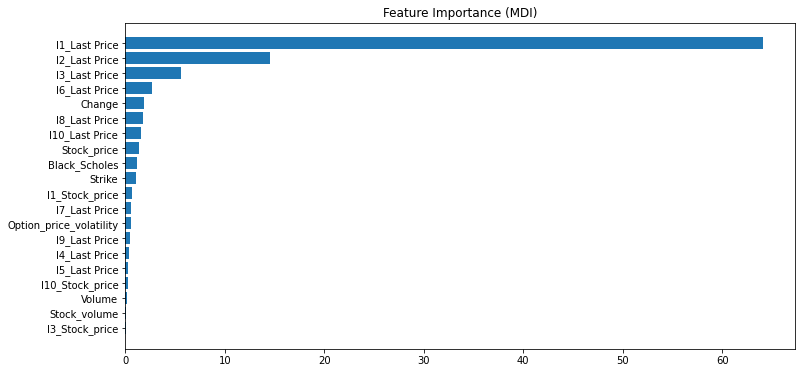

In [49]:
# see feature importance
import matplotlib.pyplot as plt
feature_importance = cb.feature_importances_
sorted_idx = np.argsort(feature_importance)[-20:]
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))

plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.savefig('Features_CatBoost_10_05.png')
plt.show()

# Compare all models (on the test set)

### Black-Scholes model

In [50]:
from scipy.stats import norm
def blackScholes(r, S, K, T, sigma, type="c"):
    "Calculate BS price of call/put"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if type == "c":
        price = S*norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
    elif type == "p":
        price = K*np.exp(-r*T)*norm.cdf(-d2, 0, 1) - S*norm.cdf(-d1, 0, 1)
    return price

In [51]:
X_test.index = np.arange(0, len(X_test))

In [52]:
X_test['Black_Scholes'] = 0
for i in range(len(X_test)):
    X_test['Black_Scholes'][i] = blackScholes(r=0.04, S=X_test['Stock_price'][i],
                                                   K=X_test['Strike'][i], 
                                                    T=X_test['Time_to_maturity'][i],
                                                   sigma=X_test['Option_price_volatility'][i])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


In [53]:
y_pred_BS = X_test['Black_Scholes'].values
y_pred_BS

array([164, 162, 170, ...,   9,   9,   8])

In [54]:
assert len(y_pred_BS) == len(y_test), 'MISMATCH'

In [55]:
MSE_BS = mean_squared_error(y_test, y_pred_BS)
MAE_BS = mean_absolute_error(y_test, y_pred_BS)
MAPE_BS = mean_absolute_percentage_error(y_test, y_pred_BS)

In [56]:
MSE_BS, MAE_BS, MAPE_BS

(164209.54739836356, 273.8139317380324, 10.927235633989296)

### Linear Regression

In [57]:
dataset_linreg = dataset_CB.copy()
dataset_linreg = pd.get_dummies(dataset_linreg, drop_first=True)

In [58]:
train = dataset_linreg.loc[dataset_linreg.index <= '2024-04-08']
test = dataset_linreg.loc[dataset_linreg.index > '2024-04-08']
len(train), len(test)

(896671, 89889)

In [59]:
X_train = train.drop('Last Price', axis=1)
y_train = train[['Last Price']]

X_test = test.drop('Last Price', axis=1)
y_test = test[['Last Price']]

In [60]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lr = linreg.predict(X_test)

In [61]:
MSE_lr = mean_squared_error(y_test, y_pred_lr)
MAE_lr = mean_absolute_error(y_test, y_pred_lr)
MAPE_lr = mean_absolute_percentage_error(y_test, y_pred_lr)

In [62]:
MSE_lr, MAE_lr, MAPE_lr

(19.21103222950264, 1.9888858965834535, 0.10559035694729145)

### Comparison

In [63]:
# CatBoost
MSE_CB, MAE_CB, MAPE_CB

(61.204607559085154, 2.866846233232093, 0.07288083070106423)

In [64]:
# Black-Scholes
MSE_BS, MAE_BS, MAPE_BS

(164209.54739836356, 273.8139317380324, 10.927235633989296)

In [65]:
# Linear Regression
MSE_lr, MAE_lr, MAPE_lr

(19.21103222950264, 1.9888858965834535, 0.10559035694729145)

**As we see, in terms of MSE and MAE, Linear Regression has shown the best result. Hence, as part of our modeling, we have confirmed that new features are extremely important for solving the problem of option pricing. Also, at the moment we can conclude that data is more important than the model (that is, the data-driven approach is ahead of model-driven).**

In [66]:
MedSE_lr = median_SE(y_test, y_pred_lr)
MedAE_lr = median_AE(y_test, y_pred_lr)
MedAPE_lr = median_APE(y_test, y_pred_lr)

In [67]:
MedSE_lr, MedAE_lr, MedAPE_lr

(0.9367678639993737, 0.9678676893043665, 0.01841019186017042)

In [68]:
dataset_CB['Last Price'].describe()

count    986560.000000
mean        114.630318
std         158.742066
min           1.000000
25%          12.550000
50%          49.340000
75%         150.000000
max        1475.050000
Name: Last Price, dtype: float64

### Completed